In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

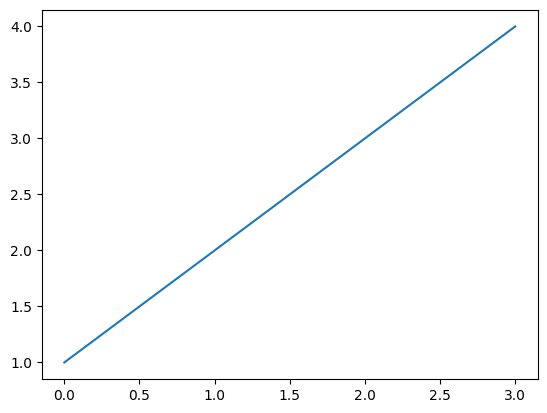

In [4]:
plt.plot([1,2,3,4])

In [5]:

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
     

In [6]:

batch_size = 32
learning_rate = 0.001
num_epochs = 20

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('./data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('./data', train=False,
                             download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [9]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [10]:
valid_size = 0.2
test_size = 0.1
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices) 

In [11]:
split = int(np.floor(valid_size * num_train)) # 0.2 * 10000
print(split)
train_idx, valid_idx = indices[split:], indices[:split] # train 8000, valid 2000 개씩 indices 리스트에서 랜덤한 인덱스 가져오기 
print(len(train_idx), len(valid_idx))

10000
40000 10000


In [12]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


In [14]:
images, labels = next(iter(test_loader))

In [15]:
images.shape

torch.Size([32, 3, 224, 224])

In [16]:
labels.shape

torch.Size([32])

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

working on gpu


In [18]:
device

device(type='cuda')

In [19]:

model = models.resnet50(pretrained=True)


D:\asy10\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\asy10\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
for n, p in model.named_parameters():
    if 'fc' not in n:
        p.requires_grad = False

In [21]:


num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

working on gpu


In [25]:
from tqdm import tqdm

In [28]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape) # 모델의 출력과, 실제 정답 비교 
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
    scheduler.step()
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'resnet_50_batch_32_model_cifar.pt')
        valid_loss_min = valid_loss[e]

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.10it/s]


Epoch: 0 	Training Loss: 0.624181 	Validation Loss: 0.937597
Epoch: 0 	Training accuracy: 0.794225 	Validation accuracy: 0.734625
Validation loss decreased (inf --> 0.937597).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.13it/s]


Epoch: 1 	Training Loss: 0.477306 	Validation Loss: 0.475479
Epoch: 1 	Training accuracy: 0.836500 	Validation accuracy: 0.835663
Validation loss decreased (0.937597 --> 0.475479).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.24it/s]


Epoch: 2 	Training Loss: 0.461838 	Validation Loss: 0.472566
Epoch: 2 	Training accuracy: 0.839775 	Validation accuracy: 0.836961
Validation loss decreased (0.475479 --> 0.472566).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.28it/s]


Epoch: 3 	Training Loss: 0.455958 	Validation Loss: 0.474974
Epoch: 3 	Training accuracy: 0.842675 	Validation accuracy: 0.836661


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.15it/s]


Epoch: 4 	Training Loss: 0.459110 	Validation Loss: 0.469765
Epoch: 4 	Training accuracy: 0.841100 	Validation accuracy: 0.838858
Validation loss decreased (0.472566 --> 0.469765).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.95it/s]


Epoch: 5 	Training Loss: 0.450171 	Validation Loss: 0.466628
Epoch: 5 	Training accuracy: 0.843675 	Validation accuracy: 0.837859
Validation loss decreased (0.469765 --> 0.466628).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.02it/s]


Epoch: 6 	Training Loss: 0.449437 	Validation Loss: 0.462588
Epoch: 6 	Training accuracy: 0.841600 	Validation accuracy: 0.841554
Validation loss decreased (0.466628 --> 0.462588).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.03it/s]


Epoch: 7 	Training Loss: 0.450719 	Validation Loss: 0.470060
Epoch: 7 	Training accuracy: 0.842125 	Validation accuracy: 0.840655


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.02it/s]


Epoch: 8 	Training Loss: 0.446369 	Validation Loss: 0.460183
Epoch: 8 	Training accuracy: 0.844075 	Validation accuracy: 0.843151
Validation loss decreased (0.462588 --> 0.460183).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.07it/s]


Epoch: 9 	Training Loss: 0.447398 	Validation Loss: 0.464897
Epoch: 9 	Training accuracy: 0.845225 	Validation accuracy: 0.838658


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.83it/s]


Epoch: 10 	Training Loss: 0.443447 	Validation Loss: 0.457541
Epoch: 10 	Training accuracy: 0.846375 	Validation accuracy: 0.839856
Validation loss decreased (0.460183 --> 0.457541).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.99it/s]


Epoch: 11 	Training Loss: 0.432880 	Validation Loss: 0.454071
Epoch: 11 	Training accuracy: 0.851150 	Validation accuracy: 0.843750
Validation loss decreased (0.457541 --> 0.454071).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.96it/s]


Epoch: 12 	Training Loss: 0.437876 	Validation Loss: 0.455621
Epoch: 12 	Training accuracy: 0.848775 	Validation accuracy: 0.842552


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.97it/s]


Epoch: 13 	Training Loss: 0.434618 	Validation Loss: 0.457018
Epoch: 13 	Training accuracy: 0.850375 	Validation accuracy: 0.840256


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.99it/s]


Epoch: 14 	Training Loss: 0.434032 	Validation Loss: 0.451628
Epoch: 14 	Training accuracy: 0.848975 	Validation accuracy: 0.842652
Validation loss decreased (0.454071 --> 0.451628).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.10it/s]


Epoch: 15 	Training Loss: 0.434258 	Validation Loss: 0.451447
Epoch: 15 	Training accuracy: 0.850300 	Validation accuracy: 0.845347
Validation loss decreased (0.451628 --> 0.451447).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.98it/s]


Epoch: 16 	Training Loss: 0.435079 	Validation Loss: 0.453965
Epoch: 16 	Training accuracy: 0.850025 	Validation accuracy: 0.842851


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.81it/s]


Epoch: 17 	Training Loss: 0.433835 	Validation Loss: 0.448653
Epoch: 17 	Training accuracy: 0.849975 	Validation accuracy: 0.843750
Validation loss decreased (0.451447 --> 0.448653).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.22it/s]


Epoch: 18 	Training Loss: 0.433983 	Validation Loss: 0.460582
Epoch: 18 	Training accuracy: 0.850000 	Validation accuracy: 0.843351


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.02it/s]


Epoch: 19 	Training Loss: 0.434141 	Validation Loss: 0.463795
Epoch: 19 	Training accuracy: 0.850025 	Validation accuracy: 0.840954


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.01it/s]


Epoch: 20 	Training Loss: 0.433813 	Validation Loss: 0.453625
Epoch: 20 	Training accuracy: 0.849875 	Validation accuracy: 0.846246


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.78it/s]


Epoch: 21 	Training Loss: 0.435409 	Validation Loss: 0.456679
Epoch: 21 	Training accuracy: 0.850975 	Validation accuracy: 0.840355


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.15it/s]


Epoch: 22 	Training Loss: 0.432769 	Validation Loss: 0.449582
Epoch: 22 	Training accuracy: 0.849275 	Validation accuracy: 0.845847


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 13.90it/s]


Epoch: 23 	Training Loss: 0.429727 	Validation Loss: 0.449824
Epoch: 23 	Training accuracy: 0.852900 	Validation accuracy: 0.844449


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.03it/s]


Epoch: 24 	Training Loss: 0.432951 	Validation Loss: 0.454947
Epoch: 24 	Training accuracy: 0.850750 	Validation accuracy: 0.842452


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.06it/s]


Epoch: 25 	Training Loss: 0.433803 	Validation Loss: 0.447676
Epoch: 25 	Training accuracy: 0.849250 	Validation accuracy: 0.842552
Validation loss decreased (0.448653 --> 0.447676).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.19it/s]


Epoch: 26 	Training Loss: 0.431023 	Validation Loss: 0.453331
Epoch: 26 	Training accuracy: 0.850425 	Validation accuracy: 0.843850


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.14it/s]


Epoch: 27 	Training Loss: 0.431151 	Validation Loss: 0.451563
Epoch: 27 	Training accuracy: 0.852150 	Validation accuracy: 0.842252


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:21<00:00, 14.25it/s]


Epoch: 28 	Training Loss: 0.432448 	Validation Loss: 0.451717
Epoch: 28 	Training accuracy: 0.850400 	Validation accuracy: 0.842352


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:22<00:00, 14.19it/s]

Epoch: 29 	Training Loss: 0.430313 	Validation Loss: 0.448321
Epoch: 29 	Training accuracy: 0.851350 	Validation accuracy: 0.845847


In [30]:
classes= ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [31]:
# track test loss
test_loss = 0.0
test_acc = 0.0

class_correct = torch.zeros(100)
class_total = torch.zeros(100)

model.eval()
# iterate over test data
for data, labels in test_loader:
    # move tensors to GPU if CUDA is available
    data, labels = data.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    logits = model(data)
    # calculate the batch loss
    loss = criterion(logits, labels)
    # update test loss 
    test_loss += loss.item()
    
    ps = F.softmax(logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.reshape(top_class.shape)
    test_acc += torch.mean(equals.type(torch.float)).detach().cpu()
    
    for i in range(len(data)):
        label = labels[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader)
test_acc = test_acc/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: {:.6f}\n'.format(test_acc))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            torch.sum(class_correct[i]), torch.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Loss: 0.453526

Test Accuracy: 0.844249

Test Accuracy of plane: 84% (841/1000)
Test Accuracy of   car: 88% (885/1000)
Test Accuracy of  bird: 79% (791/1000)
Test Accuracy of   cat: 72% (727/1000)
Test Accuracy of  deer: 80% (808/1000)
Test Accuracy of   dog: 81% (816/1000)
Test Accuracy of  frog: 89% (895/1000)
Test Accuracy of horse: 87% (878/1000)
Test Accuracy of  ship: 90% (901/1000)
Test Accuracy of truck: 90% (902/1000)


In [32]:
model.load_state_dict(torch.load('resnet_50_batch_32_model_cifar.pt'))

<All keys matched successfully>

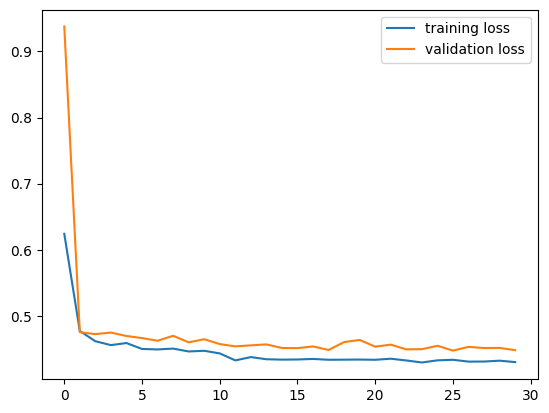

In [33]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()

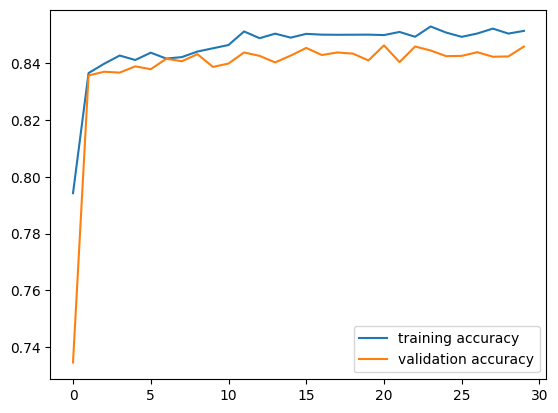

In [34]:
plt.plot(train_acc, label = 'training accuracy')
plt.plot(valid_acc, label = 'validation accuracy')
plt.legend()